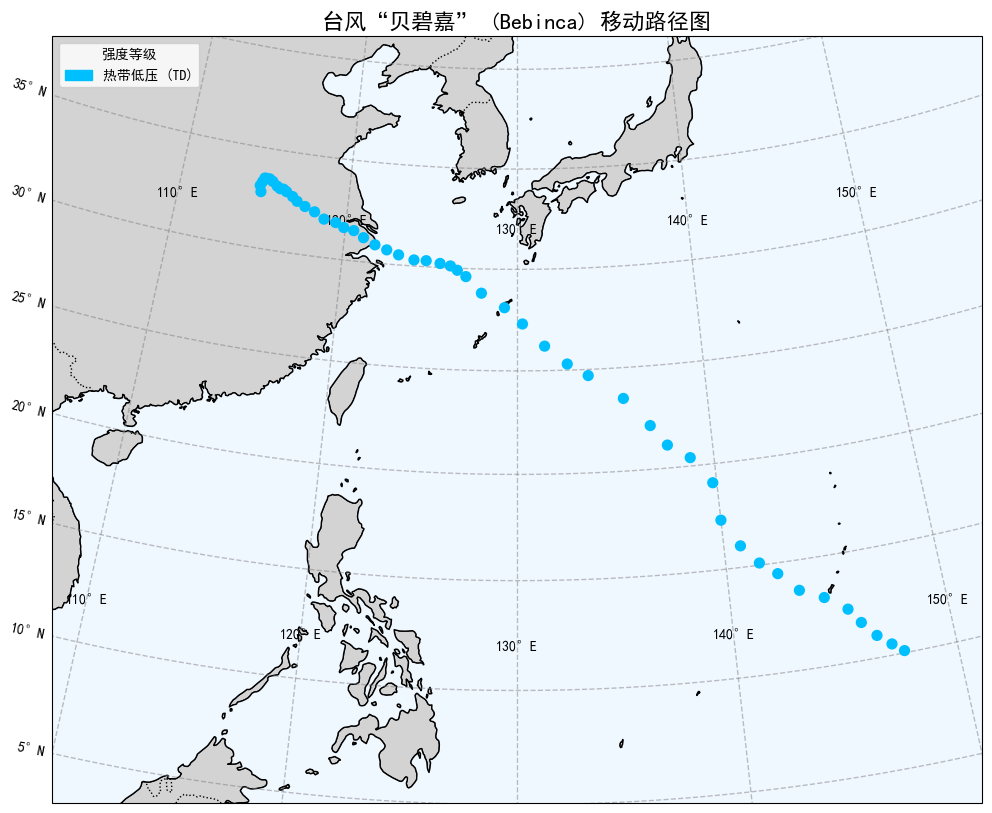

In [24]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from io import StringIO
import pandas as pd

# 1. 准备和解析数据
# 将您提供的最佳路径数据存储为字符串
bst_data = """
66666 2413   51 0014 2413 0 3 BEBINCA                      20250301
2024090912 1 101 1476 1002     13
2024090918 1 105 1471 1002     13
2024091000 1 110 1465 1002     13
2024091006 1 117 1459 1000     15
2024091012 2 124 1454  998     18
2024091018 2 131 1444  995     20
2024091100 2 136 1433  990     23
2024091106 2 145 1424  990     23
2024091112 3 151 1416  985     25
2024091118 3 160 1408  985     25
2024091200 3 173 1400  982     28
2024091206 3 191 1398  980     30
2024091212 3 204 1388  980     30
2024091218 3 211 1377  985     25
2024091300 2 221 1369  990     23
2024091306 2 235 1356  990     23
2024091312 2 247 1338  990     23
2024091318 2 253 1327  990     23
2024091400 3 262 1315  985     25
2024091406 3 273 1303  982     28
2024091412 3 281 1293  980     30
2024091418 4 288 1280  975     33
2024091500 4 296 1271  970     38
2024091503 4 299 1266  970     38
2024091506 4 301 1262  968     40
2024091509 4 302 1256  968     40
2024091512 4 303 1248  968     40
2024091515 4 303 1241  968     40
2024091518 5 305 1232  965     42
2024091521 5 307 1225  965     42
2024091600 5 309 1218  965     42
2024091603 4 312 1211  975     38
2024091606 4 315 1205  978     33
2024091609 3 316 1199  980     30
2024091612 3 318 1194  985     28
2024091615 2 319 1187  990     23
2024091618 2 322 1181  995     20
2024091621 2 324 1175  998     18
2024091700 2 326 1170  998     18
2024091703 1 328 1167 1002     15
2024091706 1 330 1163 1002     15
2024091709 1 331 1161 1002     15
2024091712 1 331 1159 1005     13
2024091715 1 332 1157 1005     13
2024091718 1 334 1154 1005     13
2024091721 1 335 1152 1005     13
2024091800 0 335 1150 1008     10
2024091803 0 335 1149 1008     10
2024091806 0 333 1148 1008     10
2024091809 0 331 1147 1008     10
2024091812 0 328 1148 1008     10
"""

# 使用 StringIO 将字符串模拟成文件，并只读取路径数据
data_io = StringIO(bst_data)
lines = data_io.readlines()[1:] # 跳过第一行表头

# 解析每一行数据
records = []
for line in lines:
    line = line.strip()   #移除开头和结尾所有多余的空白字符
    if not line:
        continue          #跳过当前这一轮循环中余下的代码
    
    # 按照固定宽度解析
    lat = int(line[13:16]) / 10.0
    lon = int(line[17:21]) / 10.0
    # 原代码：
    # wind_speed = int(line[32:35].strip()) # m/s
    
    # 修复后代码：
    try:
        wind_speed_str = line[32:35].strip()
        if wind_speed_str and wind_speed_str != 'BIN' and wind_speed_str.isdigit():
            wind_speed = int(wind_speed_str) # m/s
        else:
            wind_speed = 0  # 或者设置为None或其他默认值
    except ValueError:
        wind_speed = 0  # 处理转换异常情况
    
    records.append({'lat': lat, 'lon': lon, 'wind': wind_speed})

df = pd.DataFrame(records)

# 2. 定义强度分类和颜色
def get_intensity(wind_ms):
    if wind_ms >= 41.5:
        return '强台风 (STY)', '#FF0000' # 红色
    elif wind_ms >= 32.7:
        return '台风 (TY)', '#FFA500' # 橙色
    elif wind_ms >= 24.5:
        return '强热带风暴 (STS)', '#FFFF00' # 黄色
    elif wind_ms >= 17.2:
        return '热带风暴 (TS)', '#00FF00' # 绿色
    else:
        return '热带低压 (TD)', '#00BFFF' # 蓝色

df['intensity_name'], df['color'] = zip(*df['wind'].apply(get_intensity))


# 3. 开始绘图
# 设置中文字体，以防乱码
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 创建地图画布
fig = plt.figure(figsize=(12, 10))
proj = ccrs.LambertConformal(central_longitude=130, central_latitude=25)
ax = fig.add_subplot(1, 1, 1, projection=proj)

# 设置地图范围
ax.set_extent([110, 150, 5, 40], crs=ccrs.PlateCarree())

# 添加地图元素
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='aliceblue')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)

# 绘制网格线
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# 绘制台风路径
# 绘制整条黑色路径线
#ax.plot(df['lon'], df['lat'], color='black', linewidth=1.5, transform=ccrs.PlateCarree(), label='路径')

# 绘制不同强度的散点
for name, color in df[['intensity_name', 'color']].drop_duplicates().values:
    subset = df[df['intensity_name'] == name]
    ax.scatter(subset['lon'], subset['lat'], c=subset['color'], s=50, 
               transform=ccrs.PlateCarree(), zorder=10)

# 创建图例
legend_patches = [mpatches.Patch(color=color, label=name) 
                  for name, color in df[['intensity_name', 'color']].drop_duplicates().sort_values(by='intensity_name').values]

plt.legend(handles=legend_patches, title='强度等级', loc='upper left')

# 添加标题
ax.set_title("台风“贝碧嘉” (Bebinca) 移动路径图", fontsize=16)

# 显示图像
plt.show()

正在加载地图数据...
地图数据加载完毕。


C:\Users\ROG\AppData\Local\Temp\ipykernel_25332\869072215.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


图像已成功保存为: typhoon_bebinca_track_final.png


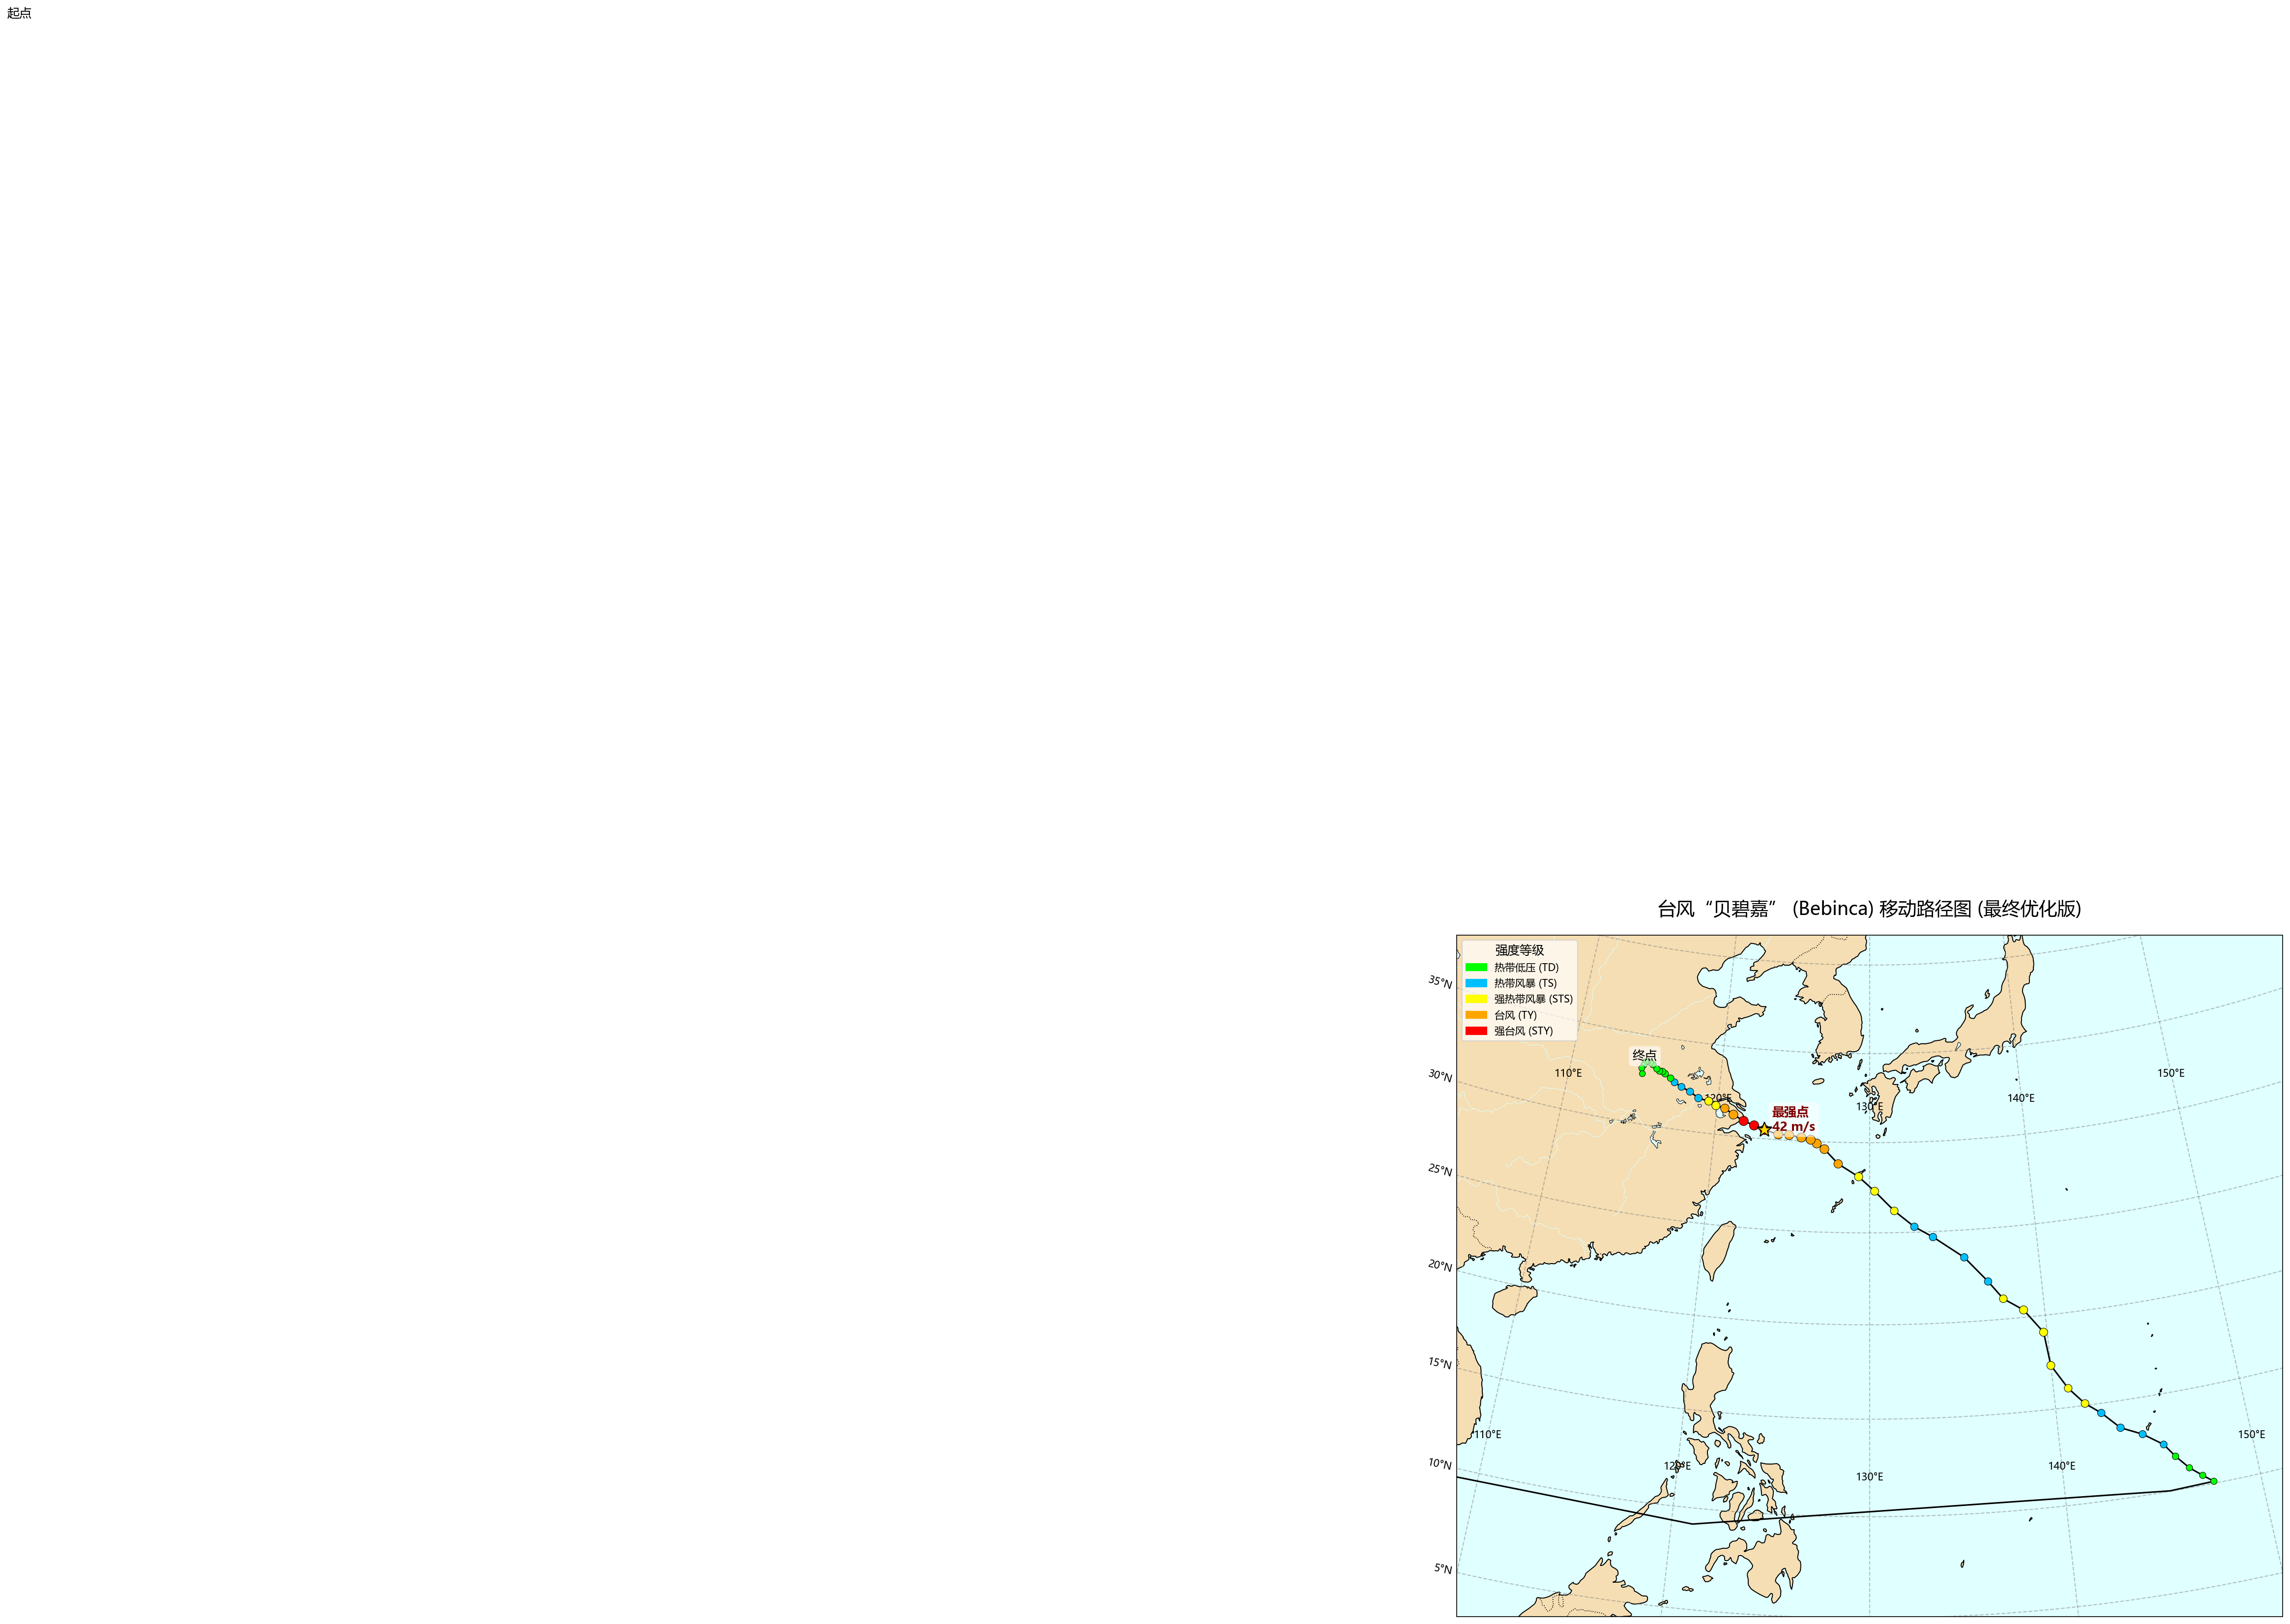

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from io import StringIO
import pandas as pd
import re
from pandas.api.types import CategoricalDtype

# --- 1. 数据准备和解析部分（无变动）---
bst_data = """
66666 2413   51 0014 2413 0 3 BEBINCA                      20250301
2024090912 1 101 1476 1002     13
2024090918 1 105 1471 1002     13
2024091000 1 110 1465 1002     13
2024091006 1 117 1459 1000     15
2024091012 2 124 1454  998     18
2024091018 2 131 1444  995     20
2024091100 2 136 1433  990     23
2024091106 2 145 1424  990     23
2024091112 3 151 1416  985     25
2024091118 3 160 1408  985     25
2024091200 3 173 1400  982     28
2024091206 3 191 1398  980     30
2024091212 3 204 1388  980     30
2024091218 3 211 1377  985     25
2024091300 2 221 1369  990     23
2024091306 2 235 1356  990     23
2024091312 2 247 1338  990     23
2024091318 2 253 1327  990     23
2024091400 3 262 1315  985     25
2024091406 3 273 1303  982     28
2024091412 3 281 1293  980     30
2024091418 4 288 1280  975     33
2024091500 4 296 1271  970     38
2024091503 4 299 1266  970     38
2024091506 4 301 1262  968     40
2024091509 4 302 1256  968     40
2024091512 4 303 1248  968     40
2024091515 4 303 1241  968     40
2024091518 5 305 1232  965     42
2024091521 5 307 1225  965     42
2024091600 5 309 1218  965     42
2024091603 4 312 1211  975     38
2024091606 4 315 1205  978     33
2024091609 3 316 1199  980     30
2024091612 3 318 1194  985     28
2024091615 2 319 1187  990     23
2024091618 2 322 1181  995     20
2024091621 2 324 1175  998     18
2024091700 2 326 1170  998     18
2024091703 1 328 1167 1002     15
2024091706 1 330 1163 1002     15
2024091709 1 331 1161 1002     15
2024091712 1 331 1159 1005     13
2024091715 1 332 1157 1005     13
2024091718 1 334 1154 1005     13
2024091721 1 335 1152 1005     13
2024091800 0 335 1150 1008     10
2024091803 0 335 1149 1008     10
2024091806 0 333 1148 1008     10
2024091809 0 331 1147 1008     10
2024091812 0 328 1148 1008     10
"""
data_io = StringIO(bst_data)
lines = data_io.readlines()[1:]
records = []
for line in lines:
    parts = re.split(r'\s+', line.strip())
    if len(parts) < 6: continue
    records.append({
        'lat': float(parts[2]) / 10.0,
        'lon': float(parts[3]) / 10.0,
        'wind': int(parts[5])
    })
df = pd.DataFrame(records)

def get_intensity(wind_ms):
    if wind_ms >= 51.0: return '超强台风 (Super TY)', '#FF00FF'
    elif wind_ms >= 41.5: return '强台风 (STY)', '#FF0000'
    elif wind_ms >= 32.7: return '台风 (TY)', '#FFA500'
    elif wind_ms >= 24.5: return '强热带风暴 (STS)', '#FFFF00'
    elif wind_ms >= 17.2: return '热带风暴 (TS)', '#00BFFF'
    else: return '热带低压 (TD)', '#00FF00'

df['intensity_name'], df['color'] = zip(*df['wind'].apply(get_intensity))

intensity_order = [
    '热带低压 (TD)', '热带风暴 (TS)', '强热带风暴 (STS)', 
    '台风 (TY)', '强台风 (STY)', '超强台风 (Super TY)'
]
cat_type = CategoricalDtype(categories=intensity_order, ordered=True)
df['intensity_name'] = df['intensity_name'].astype(cat_type)
unique_intensities = df[['intensity_name', 'color']].drop_duplicates().sort_values('intensity_name')

# --- 绘图部分 ---
try:
    plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'PingFang TC', 'SimHei', 'Heiti TC']
    plt.rcParams['axes.unicode_minus'] = False
except Exception as e:
    print(f"未能设置中文字体: {e}")

# 【优化】使用 plt.subplots() 创建画布和绘图区，更简洁
fig, ax = plt.subplots(
    figsize=(15, 12),
    dpi=150,
    subplot_kw={'projection': ccrs.LambertConformal(central_longitude=130, central_latitude=25)}
)

ax.set_extent([110, 150, 5, 40], crs=ccrs.PlateCarree())

print("正在加载地图数据...")
# 【优化】使用更高分辨率的 '50m' 地图数据，线条更平滑
ax.add_feature(cfeature.LAND.with_scale('50m'), edgecolor='black', facecolor='#F5DEB3', zorder=0)
ax.add_feature(cfeature.OCEAN.with_scale('50m'), facecolor='#E0FFFF', zorder=0)
ax.add_feature(cfeature.BORDERS.with_scale('50m'), linestyle=':', linewidth=0.8, zorder=1)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.8, zorder=1)
ax.add_feature(cfeature.LAKES, facecolor='#E0FFFF', edgecolor='black', linewidth=0.5, zorder=1)
ax.add_feature(cfeature.RIVERS, edgecolor='#E0FFFF', linewidth=0.5, zorder=1)
print("地图数据加载完毕。")

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# 【优化】为路径线和散点设置不同的 zorder，确保散点在路径线上方
ax.plot(df['lon'], df['lat'], color='black', linewidth=1.5, transform=ccrs.PlateCarree(), label='路径', zorder=2)
# 【优化】调整散点大小公式，让弱风点也有一定大小，并增加描边
ax.scatter(df['lon'], df['lat'], c=df['color'], s=df['wind']*1.5 + 20, 
           transform=ccrs.PlateCarree(), zorder=3, edgecolors='black', linewidth=0.5)

# 【优化】为标注文本添加半透明背景，增强可读性
text_bbox = dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.6, edgecolor='none')
start_point = df.iloc[0]
end_point = df.iloc[-1]
peak_point = df.loc[df['wind'].idxmax()]
ax.text(start_point['lon'], start_point['lat'] + 0.8, '起点', transform=ccrs.PlateCarree(), fontsize=12, ha='center', bbox=text_bbox, zorder=4)
ax.text(end_point['lon'], end_point['lat'] + 0.8, '终点', transform=ccrs.PlateCarree(), fontsize=12, ha='center', bbox=text_bbox, zorder=4)
ax.plot(peak_point['lon'], peak_point['lat'], marker='*', color='gold', markersize=15, 
        transform=ccrs.PlateCarree(), markeredgecolor='black', zorder=5)
ax.text(peak_point['lon'] + 0.5, peak_point['lat'], f"最强点\n{peak_point['wind']} m/s", 
        transform=ccrs.PlateCarree(), fontsize=12, color='maroon', fontweight='bold', bbox=text_bbox, zorder=4)

# 【优化】为图例添加边框和半透明背景
legend_patches = [mpatches.Patch(color=color, label=name) 
                  for name, color in unique_intensities.values]
legend = plt.legend(handles=legend_patches, title='强度等级', loc='upper left', fontsize=10, title_fontsize=12, frameon=True)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(0.7)

ax.set_title("台风“贝碧嘉” (Bebinca) 移动路径图", fontsize=18, pad=20)

# 【优化】使用 tight_layout 自动调整，确保所有元素显示完整
plt.tight_layout()

# 【优化】保存为高清晰度、无白边的图片文件
output_filename = 'typhoon_bebinca_track_final.png'
fig.savefig(output_filename, dpi=300, bbox_inches='tight', pad_inches=0.1)
print(f"图像已成功保存为: {output_filename}")

# 显示图像
plt.show()

图像已保存为 typhoon_bebinca_track.png


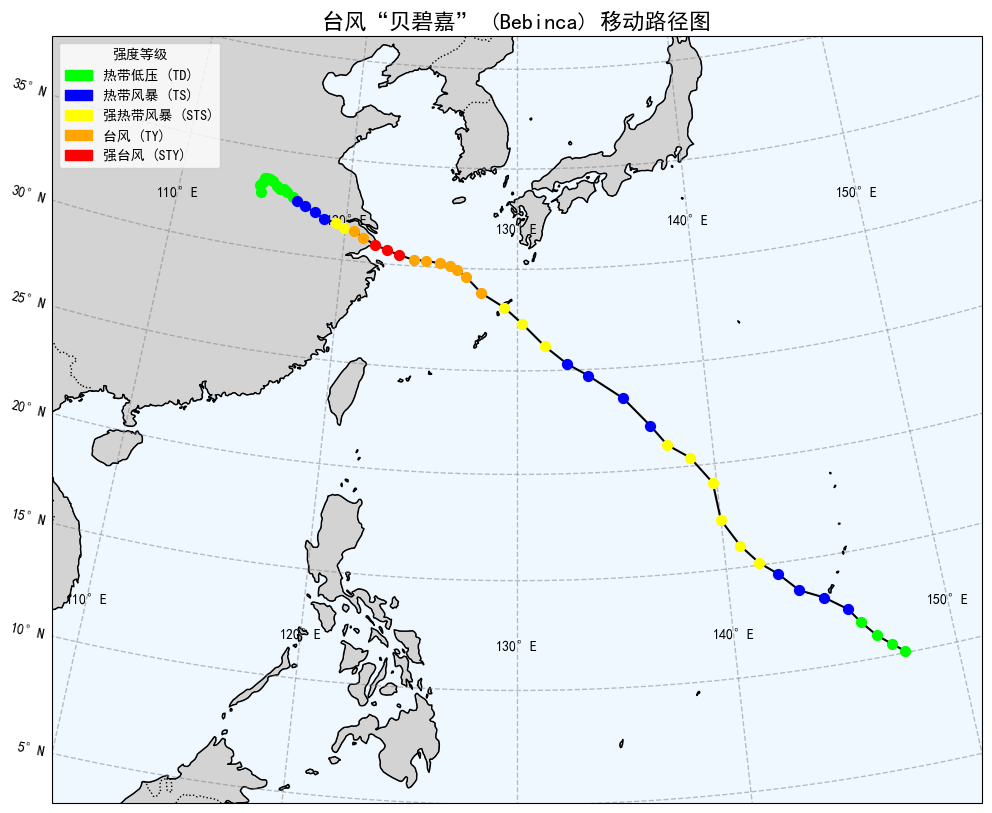

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from io import StringIO
import pandas as pd

# 1. 准备和解析数据
# 将您提供的最佳路径数据存储为字符串
bst_data = """
2024090912 1 101 1476 1002     13
2024090918 1 105 1471 1002     13
2024091000 1 110 1465 1002     13
2024091006 1 117 1459 1000     15
2024091012 2 124 1454  998     18
2024091018 2 131 1444  995     20
2024091100 2 136 1433  990     23
2024091106 2 145 1424  990     23
2024091112 3 151 1416  985     25
2024091118 3 160 1408  985     25
2024091200 3 173 1400  982     28
2024091206 3 191 1398  980     30
2024091212 3 204 1388  980     30
2024091218 3 211 1377  985     25
2024091300 2 221 1369  990     23
2024091306 2 235 1356  990     23
2024091312 2 247 1338  990     23
2024091318 2 253 1327  990     23
2024091400 3 262 1315  985     25
2024091406 3 273 1303  982     28
2024091412 3 281 1293  980     30
2024091418 4 288 1280  975     33
2024091500 4 296 1271  970     38
2024091503 4 299 1266  970     38
2024091506 4 301 1262  968     40
2024091509 4 302 1256  968     40
2024091512 4 303 1248  968     40
2024091515 4 303 1241  968     40
2024091518 5 305 1232  965     42
2024091521 5 307 1225  965     42
2024091600 5 309 1218  965     42
2024091603 4 312 1211  975     38
2024091606 4 315 1205  978     33
2024091609 3 316 1199  980     30
2024091612 3 318 1194  985     28
2024091615 2 319 1187  990     23
2024091618 2 322 1181  995     20
2024091621 2 324 1175  998     18
2024091700 2 326 1170  998     18
2024091703 1 328 1167 1002     15
2024091706 1 330 1163 1002     15
2024091709 1 331 1161 1002     15
2024091712 1 331 1159 1005     13
2024091715 1 332 1157 1005     13
2024091718 1 334 1154 1005     13
2024091721 1 335 1152 1005     13
2024091800 0 335 1150 1008     10
2024091803 0 335 1149 1008     10
2024091806 0 333 1148 1008     10
2024091809 0 331 1147 1008     10
2024091812 0 328 1148 1008     10
"""

# 使用 StringIO 将字符串模拟成文件，并只读取路径数据
data_io = StringIO(bst_data)
lines = data_io.readlines() # 跳过第一行表头

# --- 改进的数据解析逻辑 ---
records = []
for line in lines:
    line = line.strip()
    if not line:
        continue
    line = line.replace('\xa0', ' ')
    parts = line.split()
    if len(parts) >= 6:
        try:
            lat = int(parts[2]) / 10.0
            lon = int(parts[3]) / 10.0
            wind_speed = int(parts[5])
            records.append({'lat': lat, 'lon': lon, 'wind': wind_speed})
        except (ValueError, IndexError) as e:
            print(f"Skipping line due to parsing error: {line} -> {e}")
            continue

df = pd.DataFrame(records)

# 2. 定义强度分类和颜色 (优化后的颜色和分类)
def get_intensity(wind_ms):
    if wind_ms >= 51.0:
        return '超强台风 (SuperTY)', '#FF00FF' # 紫色
    elif wind_ms >= 41.5:
        return '强台风 (STY)', '#FF0000' # 红色
    elif wind_ms >= 32.7:
        return '台风 (TY)', '#FFA500' # 橙色
    elif wind_ms >= 24.5:
        return '强热带风暴 (STS)', '#FFFF00' # 黄色
    elif wind_ms >= 17.2:
        return '热带风暴 (TS)', '#0000FF' # 蓝色
    else:
        return '热带低压 (TD)', '#00FF00' # 绿色

df['intensity_name'], df['color'] = zip(*df['wind'].apply(get_intensity))

# 3. 开始绘图
# 设置中文字体，以防乱码
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 创建地图画布
fig = plt.figure(figsize=(12, 10))
proj = ccrs.LambertConformal(central_longitude=130, central_latitude=25)
ax = fig.add_subplot(1, 1, 1, projection=proj)

# 设置地图范围
ax.set_extent([110, 150, 5, 40], crs=ccrs.PlateCarree())

# 添加地图元素
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='aliceblue')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)

# 绘制网格线
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# 绘制台风路径
ax.plot(df['lon'], df['lat'], color='black', linewidth=1.5, transform=ccrs.PlateCarree())

# --- 优化的图例和散点绘制 ---
# 创建一个有序的强度列表，用于排序图例
intensity_order = [
    '热带低压 (TD)', '热带风暴 (TS)', '强热带风暴 (STS)', 
    '台风 (TY)', '强台风 (STY)', '超强台风 (SuperTY)'
]
# 获取数据中出现的强度等级，并按上述列表排序
unique_intensities = df[['intensity_name', 'color']].drop_duplicates()
unique_intensities['intensity_name'] = pd.Categorical(
    unique_intensities['intensity_name'], 
    categories=intensity_order, 
    ordered=True
)
unique_intensities = unique_intensities.sort_values('intensity_name')

# 按照排序后的强度绘制散点和创建图例
legend_patches = []
for _, row in unique_intensities.iterrows():
    name, color = row['intensity_name'], row['color']
    subset = df[df['intensity_name'] == name]
    ax.scatter(subset['lon'], subset['lat'], c=color, s=50, 
               transform=ccrs.PlateCarree(), zorder=10)
    legend_patches.append(mpatches.Patch(color=color, label=name))

plt.legend(handles=legend_patches, title='强度等级', loc='upper left')
# --- 优化结束 ---

# 添加标题
ax.set_title("台风“贝碧嘉” (Bebinca) 移动路径图", fontsize=16)

# 显示或保存图像
# plt.show()
plt.savefig("typhoon_bebinca_track.png", dpi=300)
print("图像已保存为 typhoon_bebinca_track.png")

In [2]:
df

,lat,lon,wind,intensity_name,color
0,5.1,1.4,0,热带低压 (TD),#00FF00
1,10.1,147.6,13,热带低压 (TD),#00FF00
2,10.5,147.1,13,热带低压 (TD),#00FF00
3,11.0,146.5,13,热带低压 (TD),#00FF00
4,11.7,145.9,15,热带低压 (TD),#00FF00
5,12.4,145.4,18,热带风暴 (TS),#0000FF
6,13.1,144.4,20,热带风暴 (TS),#0000FF
7,13.6,143.3,23,热带风暴 (TS),#0000FF
8,14.5,142.4,23,热带风暴 (TS),#0000FF
9,15.1,141.6,25,强热带风暴 (STS),#FFFF00
